# Welcome to H.M.M.S - Human Mouse Movement Simulator

## Imports

In [233]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import math
import datetime
import time

## Setting up the dataset

In [234]:
# A function used when creating the dataset, where we check if xy differ in direction and return true if it does
def xy_differ(x1, y1, x2, y2):
    if x1 >= 0 and x2 < 0:
        return True
    elif x1 <= 0 and x2 > 0:
        return True
    elif y1 >= 0 and y2 < 0:
        return True
    elif y1 <= 0 and y2 > 0:
        return True
    else:
        return False

In [235]:
# Sets up the path dataset used in the path generation model, it creates distance left as input and the move to be made as label
def setup_path_dataset(dataset):
    data = []
    for path in dataset:
        f_path = path.copy()
        if len(path) > 0:
            end = [path[len(path)-1][0],path[len(path)-1][1],path[len(path)-1][2]]
            f_path.pop(len(path)-1)
        else:
            end = [path[0][0],path[0][1],path[0][2]]

        inputs = np.zeros([len(f_path), 2])
        inputs[0] = [end[0], end[1]]
        for i in range(len(f_path)-1):
            # Since we want next time to have been moved closer to our targeted point
            end[0] = end[0] - f_path[i][0]
            end[1] = end[1] - f_path[i][1]
            inputs[i+1] = [end[0],end[1]]

        labels = np.zeros([len(f_path), 2])
        for i in range(len(f_path)):
            labels[i] = [f_path[i][0],f_path[i][1]]

        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).float()
        data.append((inputs, labels))
    return data

In [236]:
#Sets up the time dataset used in the time generation model, it creates moves to make as input and the time it should take as label
def setup_time_dataset(dataset):
    data = []
    for path in dataset:
        inputs = np.zeros([len(path)-1, 2])
        for i in range(len(inputs)):
            # Since we want next time to have been moved closer to our targeted point
            inputs[i] = [path[i][0],path[i][1]]

        labels = np.zeros([len(path)-1, 1])
        for i in range(len(labels)):
            labels[i] = [path[i][2]]

        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).float()
        data.append((inputs, labels))
    return data

In [238]:
file = open("./data/1.5k_1ms.txt")
dataset = []

# Loop over the contents of the file, line by line
for line in file:
    # Our dataset consists of each line containing one path, and each point in the path is a triplet of data
    line = line.replace("[","").replace("]","")
    path = []
    x, y, t = 0, 0, 0
    zeros = 0
    lines = line.split("),")
    
    # We loop over every triplet point in the current path
    for triplet in lines:
        numbs = (triplet.split("(")[1]).split(",")
        
        # We check if the triplet we are on is the last one, if it is then we can create the current move and add the size of the movement
        # We are required to do this due to each path always ends with a triplet that sums up the whole path, (x_total, y_total, time_total)
        if lines.index(triplet) == len(lines)-1:
            path.append((x,y,t))
            path.append((int(numbs[0]),int(numbs[1]),int(numbs[2].split(")")[0])))
            break;
        
        curr_x = int(numbs[0])
        curr_y = int(numbs[1])
        
        # Counting up if we have stood still for too long, this doesnt always count consecutive halts 
        if curr_x == 0 and curr_y == 0:
            zeros += 1
        
        x += curr_x
        y += curr_y
        t += int(numbs[2].split(")")[0])
        
        # Check if the distance is met, if the direction is changed or if the point has stood still for too long 
        if math.sqrt((x**2)+(y**2)) > 3 or xy_differ(x, y, curr_x, curr_y) or zeros > 2:
            path.append((x, y, t))
            x, y, t, zeros = 0, 0, 0, 0
        
    dataset.append(path)

# Setup each dataset for each network
path_dataset = setup_path_dataset(dataset)
time_dataset = setup_time_dataset(dataset)
print("Number of paths: {}".format(len(dataset)))

Number of paths: 1503


In [270]:
# Generates a path between a starting point (s) and a target point (t), can be made to generate time on that path aswell
def generate_path(path_model, s, t, time_model=None,):
    pred_path = []
    wanted_loc = np.array([t[0], t[1]]);
    curr_loc = np.array([s[0], s[1]])
    is_stuck = 0
    prev_dist = 0
    moving_wrongly = 0

    delta_loc = wanted_loc-curr_loc
    dist = np.sqrt(delta_loc[0]**2+delta_loc[1]**2)

    # Looping new movement in the path while we have a distance from the target point
    while dist > 1:
        prev_dist = dist
        with torch.no_grad():
            inp = torch.from_numpy(delta_loc).float().to(device)
            pred_movement = path_model(inp)
            
            # If the function got supplied a model for generating time, we generate a time for this movement
            if time_model:
                pred_time = time_model(pred_movement)
                pred_time = pred_time.cpu().numpy()[0]
        
            pred_movement = pred_movement.cpu().numpy()

        if time_model:
            pred_path.append((int(np.round(pred_movement[0])), int(np.round(pred_movement[1])), pred_time))
        else:
            pred_path.append((int(np.round(pred_movement[0])), int(np.round(pred_movement[1])), 0))
            
        curr_loc[0] = curr_loc[0] + int(np.round(pred_movement[0]))
        curr_loc[1] = curr_loc[1] + int(np.round(pred_movement[1]))

        delta_loc = wanted_loc-curr_loc
        dist = np.sqrt(delta_loc[0]**2+delta_loc[1]**2)
        
        #If no more movement is generated stop generating movement
        if prev_dist == dist:
            is_stuck += 1
            if is_stuck > 2:
                break;
        else:
            is_stuck = 0
            
        # If moving the wrong way for too long stop generating movement
        if prev_dist < dist:
            moving_wrongly += 1
            if moving_wrongly > 4:
                break;
        else:
            moving_wrongly = 0
        
    # Summing up the final time it took to take the path
    total_time = 0
    for p in pred_path:
        total_time += p[2]
        
    pred_path.append((t[0], t[1], total_time))

    #print("Path generated! {} movements needed to complete path".format(len(pred_path)-1))
    return pred_path

In [433]:
# Visualizes a path, can take a time model as argument and also visualize the acceleration on the path
# Can be inputed a number of points to generate a path to, or be made to generate points on a circle
# Two different end results are provided by either supplying a number or not, if you supply a number the function
# treats the results as being a image to be saved, otherwise just displays the plot generated.
def visualize(path_model, time_model=None, time_only=False, nr=None, points=None, gen_circle=False, gen_circle_radius=200, gen_circle_nr_points=12, unique_cols="None", save_folder="./generated_paths/"):
    paths = []
    cols = ["r", "g", "b", "y", "m", "c"]

    # If no points are sent in we either generate points on a circle or take four predefined points to generate a path on
    if points == None:
        points = []
        if gen_circle:
            for i in range(1,gen_circle_nr_points+1):
                points.append((gen_circle_radius * math.cos(2*math.pi/gen_circle_nr_points*i), gen_circle_radius * math.sin(2*math.pi/gen_circle_nr_points*i)))
        else:
            points = [(500,500),(-500,500),(-500,-500),(500,-500)]
                
    # Generate paths to each point
    for p in points:
        paths.append(generate_path(path_model, (0, 0), p, time_model))
    
    xs = []
    ys = []
    
    if time_model:
        ts = []
    
    # Create a plottable display of the movement generated 
    for i in range(len(paths)):
        xs.append([0])
        ys.append([0])
        
        if time_model:
            ts.append([0])
            
        prev_i = 1
        for p in paths[i]:
            xs[i].append(p[0]+xs[i][prev_i-1])
            ys[i].append(p[1]+ys[i][prev_i-1])
            
            if time_model:
                ts[i].append(int(p[2]*1000))
            
            prev_i += 1
        
    if time_only:
        for t in ts:
            # We take the time multiplied by 1000 because plt only plots on integers, 
            # hence by multiplying it with 1000 we still contain some decimals and the resulting acceleration isnt hacky
            plt.title("Acceleration plot of path {}\nTotal time taken: {}ms".format(ts.index(t), t[-1]/1000))
            plt.xlabel("Point number in path")
            plt.ylabel("Time each point on path takes multiplied by 1000")
            plt.plot(range(len(t)-1), t[:-1], cols[ts.index(t) % len(cols)])
    else:
        # Plot movement paths to each point
        for i in range(len(xs)):
            for z in range(0, len(xs[i])-2):
                if unique_cols == "both" or unique_cols == "path":
                    plt.plot(xs[i][z:z+2], ys[i][z:z+2], cols[i % len(cols)]+'-')
                else:
                    plt.plot(xs[i][z:z+2], ys[i][z:z+2], 'r-')
                    

        # Plot every end point that is to be generated
        for p in points:
            plt.text(p[0]+10, p[1]+10, str(points.index(p)))
            plt.plot(p[0], p[1], "go")

        #Plot the blue starting point
        plt.plot(0, 0, "o") 

    # If a number is supplied save the graph to a file for display later, if not just display it
    if nr != None:
        plt.title("Epoch: "+str(nr))
        plt.grid()
        plt.savefig(save_folder+""+str(nr)+".png")
        plt.clf()
    else:
        plt.grid()
        plt.show()
        if time_model:
            plt.clf()
            for t in ts:
                plt.grid()
                # We take the time multiplied by 1000 because plt only plots on integers, 
                # hence by multiplying it with 1000 we still contain some decimals and the resulting acceleration isnt hacky
                plt.title("Acceleration plot of paths\nTotal time taken: {}ms".format(t[-1]/1000))
                plt.xlabel("Point number in path")
                plt.ylabel("Time each point on path takes multiplied by 1000")
                if unique_cols == "both" or unique_cols == "time":
                    plt.plot(range(len(t)-1), t[:-1], cols[ts.index(t) % len(cols)])
                else:
                    plt.plot(range(len(t)-1), t[:-1], 'r')
            plt.show()

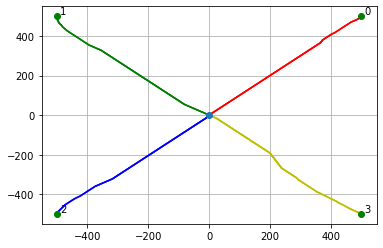

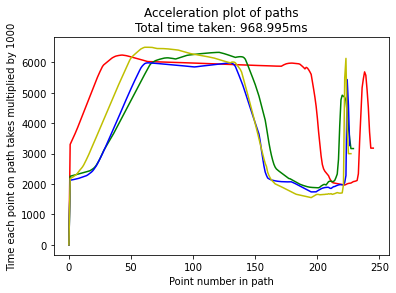

In [434]:
visualize(path_network, time_network, unique_cols="both")

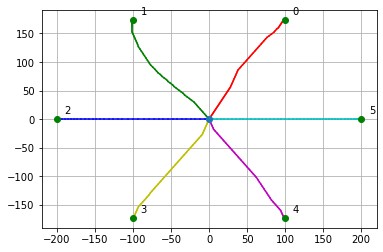

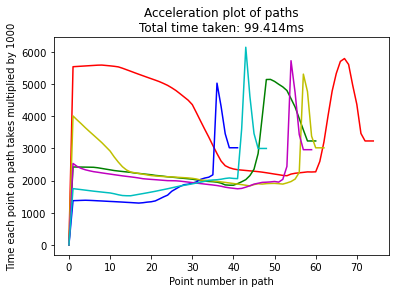

In [403]:
visualize(path_network, time_network, gen_circle=True, gen_circle_nr_points=6, unique_cols="both")

## Training the network

In [344]:
class PathNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
                        nn.Linear(2, 1000),
                        nn.LeakyReLU(),
                        nn.Linear(1000, 200),
                        nn.LeakyReLU(),
                        nn.Linear(200, 2)
                    )
    def forward(self, x):
        return self.fc(x)
    
class TimeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
                        nn.Linear(2, 1000),
                        nn.LeakyReLU(),
                        nn.Linear(1000, 200),
                        nn.LeakyReLU(),
                        nn.Linear(200, 1),
                        nn.ReLU()
                    )
    def forward(self, x):
        return self.fc(x)

### Setting up the Path network

In [339]:
device = torch.device('cuda:0')
loss_function = nn.MSELoss()

path_network = PathNet()
path_network.to(device)

path_opt = optim.Adam(path_network.parameters(), lr=0.0001)

### Setting up the Time network

In [400]:
time_network = TimeNet()
time_network.to(device)

time_opt = optim.Adam(time_network.parameters(), lr=0.0001)

In [397]:
def train(model, dataset, optimizer, loss_function, epochs=100, visualize=False, vis_path=True, path_model=None):
    t = time.time()

    inf_found = False
    losses = []

    #Training the data
    for epoch in range(epochs):
        epoch_loss = []
        batch_nr = 0
        for inputs,labels in dataset:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            prediction = model(inputs) # Enter the i-th pos in the path into the neural network

            loss_t = loss_function(prediction, labels) # Our label will become the pos movement made by the premade dataset
            loss_t.backward()

            optimizer.step()     
            epoch_loss.append(loss_t.item())

            batch_nr = batch_nr + 1
            print(
                '\r[Train] Epoch {} [{}/{}] - Loss: {} \tProgress [{}%] \tTotal time elapsed: {}                                  '.format(
                    epoch+1, batch_nr, len(dataset), loss_t.item(), (epoch/epochs)*100, str(datetime.timedelta(seconds=round(time.time()-t)))
                ),
                end=''
            )

            if inf_found:
                break;

        if visualize:
            if vis_path:
                visualize(model, nr=epoch+1)
            else:
                visualize(path_model, time_model=model, nr=epoch+1, time_only=True, points=[(500, 500)], save_folder="./generated_times/")

        if inf_found:
            break;
        losses.append(np.average(epoch_loss))

    print('\nTime elapsed from training: {}'.format(str(datetime.timedelta(seconds=round(time.time()-t)))))
    plt.plot(range(1,len(losses)+1),losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

### Training the models

[Train] Epoch 100 [1503/1503] - Loss: 45.87795639038086 	Progress [99.0%] 	Total time elapsed: 0:14:20                                                
Time elapsed from training: 0:14:22


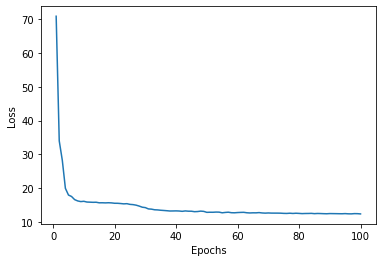

In [340]:
train(path_network, path_dataset, path_opt, loss_function, visualize=True)

[Train] Epoch 100 [1503/1503] - Loss: 0.5174180269241333 	Progress [99.0%] 	Total time elapsed: 0:10:05                                                
Time elapsed from training: 0:10:05


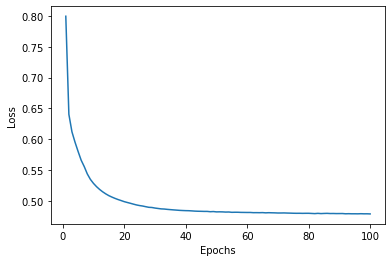

In [401]:
train(time_network, time_dataset, time_opt, loss_function, visualize=True, vis_path=False, path_model=path_network)

## Save models

In [413]:
torch.save(time_network.state_dict(), "./models/time_network_state")
torch.save(path_network.state_dict(), "./models/path_network_state")

PicklingError: Can't pickle <class '__main__.PathNet'>: it's not the same object as __main__.PathNet

## Load models

In [431]:
path = PathNet()
time = TimeNet()

path.load_state_dict(torch.load("./models/path_network_state"))
time.load_state_dict(torch.load("./models/time_network_state"))

<All keys matched successfully>

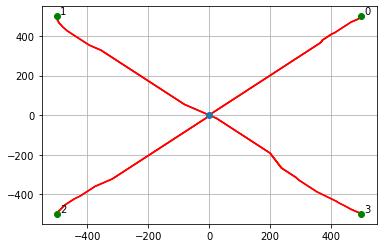

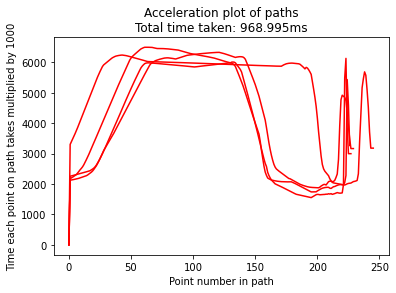

In [432]:
path.to(device)
time.to(device)
visualize(path, time)